# Plot WER

## Imports

In [62]:
import pathlib
import re
from dataclasses import dataclass
import matplotlib.pyplot as plt
from typing import List, Optional
import numpy as np

## General & constants

In [63]:
HOME_PATH = pathlib.Path.home()
EXPERIMENTS_PATH = HOME_PATH.joinpath("experiments")

experiments_used = {
    "AED": EXPERIMENTS_PATH.joinpath("25_09_08_demo1_sllm"),
    "SLLM": EXPERIMENTS_PATH.joinpath("25_10_17_sllm_d2"),
}


def get_results_path_of_experiment(experiment_path: pathlib.Path) -> pathlib.Path:
    return experiment_path.joinpath("output", "experiments")


_NUMERIC_DIR_PATTERN = re.compile(r"^\d+$")


def is_experiment_version_root(path: pathlib.Path) -> bool:
    """
    An experiment-version root is a directory that contains *at least one*
    numeric subdirectory such as "160", "320", etc.
    """
    if not path.is_dir():
        return False

    for child in path.iterdir():
        if child.is_dir() and _NUMERIC_DIR_PATTERN.match(child.name):
            return True

    return False


def get_experiment_version_paths(experiment_path: pathlib.Path) -> List[pathlib.Path]:
    exp_output_path = get_results_path_of_experiment(experiment_path)

    experiment_version_paths = []

    # BFS or DFS both fine; DFS is simpler
    stack = [exp_output_path]

    while stack:
        current = stack.pop()

        # Check if current is a valid version root
        if is_experiment_version_root(current):
            experiment_version_paths.append(current)
            # DO NOT recurse below this level: inner numeric dirs are epochs
            continue

        # Otherwise recurse into subdirectories
        for child in current.iterdir():
            if child.is_dir():
                stack.append(child)

    return experiment_version_paths


## Data

In [64]:
@dataclass
class ExperimentVersionResults:
    exp_version_name: str
    exp_version_path: pathlib.Path
    wer_per_epoch_per_eval: dict[str, list[tuple[int, float]]]
    wer_per_best_per_eval: dict[str, list[tuple[int, float]]]
    total_epochs: int = 2000


@dataclass
class ExperimentResults:
    exp_id: str
    exp_path: pathlib.Path
    exp_version_results: list[ExperimentVersionResults]

    def get_version_names(self) -> List[str]:
        return [exp_ver.exp_version_name for exp_ver in self.exp_version_results]


def read_wer_file(path: pathlib.Path) -> float:
    text = path.read_text().strip()
    return float(text)


def parse_experiment_version(version_path: pathlib.Path, multiple_lm_corrections) -> ExperimentVersionResults:
    version_name = version_path.name

    # We will collect: dataset_name -> [(step, wer_value)]
    wer_per_epoch_per_dataset = {}
    wer_per_best_per_dataset = {}

    # Traverse search configs
    for epoch in version_path.iterdir():
        if not epoch.is_dir():
            continue

        epoch_dir = _NUMERIC_DIR_PATTERN.match(epoch.name)

        # Traverse all datasets inside search config
        for dir in epoch.iterdir():
            if not dir.is_dir():
                continue

            test_wer_file = dir.joinpath("sclite", "wer")
            if test_wer_file.exists(): # Test-clean and test-other
                test_wer_value = read_wer_file(test_wer_file)
                if epoch_dir:
                    wer_per_epoch_per_dataset.setdefault(dir.name, []).append((epoch.name, test_wer_value))
                else:
                    wer_per_best_per_dataset.setdefault(dir.name, []).append((epoch.name, test_wer_value))
            else: # Devs
                dev_name = dir.name
                for dev_dir in dir.iterdir():
                    if not dev_dir.is_dir():
                        continue

                    dev_wer_file = dev_dir.joinpath("sclite", "wer")
                    if dev_wer_file.exists(): # dev-clean and dev-other
                        dev_wer_value = read_wer_file(dev_wer_file)

                        if multiple_lm_corrections:
                            dataset_name = f"{dev_name}-{dev_dir.name}"
                        else:
                            dataset_name = dev_dir.name

                        if epoch_dir:
                            wer_per_epoch_per_dataset.setdefault(dataset_name, []).append((epoch.name, dev_wer_value))
                        else:
                            wer_per_best_per_dataset.setdefault(dataset_name, []).append((epoch.name, dev_wer_value))

    return ExperimentVersionResults(
        exp_version_name=version_name,
        exp_version_path=version_path,
        wer_per_epoch_per_eval=wer_per_epoch_per_dataset,
        wer_per_best_per_eval=wer_per_best_per_dataset
    )


def load_all_experiment_results(exps_dict: dict[str, pathlib.Path], multiple_lm_corrections:bool = False) -> List[ExperimentResults]:
    all_results = []

    for exp_id, exp_path in exps_dict.items():
        print(f"Getting results for experiment {exp_id} ({exp_path})")

        # Use your helper to get all experiment version paths
        version_paths = get_experiment_version_paths(exp_path)

        version_results = [
            parse_experiment_version(version_path, multiple_lm_corrections)
            for version_path in version_paths
        ]

        if exp_id == "AED":  # TODO: improve this!!
            for version_result in version_results:
                version_result.total_epochs = 500

        exp_results = ExperimentResults(
            exp_id=exp_id,
            exp_path=exp_path,
            exp_version_results=version_results
        )

        all_results.append(exp_results)

    return all_results


experiment_results_list = load_all_experiment_results(experiments_used,
                                                      multiple_lm_corrections=False)

Getting results for experiment AED (/u/marti.juanola/experiments/25_09_08_demo1_sllm)
Getting results for experiment SLLM (/u/marti.juanola/experiments/25_10_17_sllm_d2)


In [65]:
print(experiment_results_list)

[ExperimentResults(exp_id='AED', exp_path=PosixPath('/u/marti.juanola/experiments/25_09_08_demo1_sllm'), exp_version_results=[ExperimentVersionResults(exp_version_name='v2', exp_version_path=PosixPath('/u/marti.juanola/experiments/25_09_08_demo1_sllm/output/experiments/librispeech/aed/ls960/baselines/pytorch_networks.conformer_aed_v1/v2'), wer_per_epoch_per_eval={'dev-other': [('20', 47.49), ('160', 10.97), ('40', 20.73), ('80', 14.37), ('320', 7.46), ('500', 5.44)], 'dev-clean': [('20', 35.56), ('160', 4.94), ('40', 10.51), ('80', 6.72), ('320', 3.15), ('500', 2.26)], 'test-other': [('20', 51.37), ('160', 11.26), ('40', 21.54), ('80', 15.14), ('320', 7.93), ('500', 5.57)], 'test-clean': [('20', 36.05), ('160', 4.78), ('40', 10.85), ('80', 6.66), ('320', 3.26), ('500', 2.42)]}, wer_per_best_per_eval={'test-clean': [('best', 2.45), ('best4', 2.44), ('500_old', 2.42)], 'test-other': [('best', 5.62), ('best4', 5.6), ('500_old', 5.57)], 'dev-other': [('best', 5.43), ('best4', 5.45), ('500_

## Plot WER methods

In [66]:
def _should_plot_version(name: str,
                         include: Optional[List[str]],
                         exclude: Optional[List[str]]) -> bool:
    if include:
        return name in include
    if exclude:
        return name not in exclude
    return True


def _normalize_epochs(wer_list: list[tuple[str, float]], total_epochs: int) -> list[tuple[float, float]]:
    """
    Convert ('500', 5.57) into (500/total_epochs, 5.57)
    and return in ascending epoch order.
    """
    normalized = []
    for epoch_str, wer in wer_list:
        epoch = int(epoch_str)
        norm = epoch / float(total_epochs)
        normalized.append((norm, wer))

    # Sort by normalized epoch value
    normalized.sort(key=lambda x: x[0])
    return normalized


def _plot_global(experiments: List[ExperimentResults],
                 include_versions: Optional[List[str]],
                 exclude_versions: Optional[List[str]],
                 dataset: str,
                 title: str,
                 y_log: bool = False,
                 ylim_max: Optional[float] = None,):
    """
    Produce a figure for ALL experiments together.
    """
    plt.figure(figsize=(10, 6), facecolor="white")
    plt.title(f"{title} [{dataset}]")
    plt.xlabel("Training Progress (normalized epochs)")
    plt.ylabel("WER (%)")

    plotted_any = False

    if y_log:
        plt.yscale("log")

        ax = plt.gca()

        # Set ticks appropriate for your data range (0.9 to 11)
        ticks = [1, 2, 3, 5, 10, 20, 30, 40, 50, 75, 100]
        plt.yticks(ticks, [str(t) for t in ticks])

        # Add minor ticks for the grid
        #ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10), numticks=100))
        #ax.yaxis.set_minor_formatter(NullFormatter())

        plt.ylabel("WER % (log scale)")
    else:
        plt.ylabel("WER %")

    if ylim_max is not None:
        plt.ylim(0, ylim_max)
        #plt.ylabel(f"WER % (ylim={ylim_max:.1f})")

    for exp in experiments:
        for version in exp.exp_version_results:
            if not _should_plot_version(version.exp_version_name, include_versions, exclude_versions):
                continue

            if dataset not in version.wer_per_epoch_per_eval:
                continue

            wer_list = version.wer_per_epoch_per_eval[dataset]
            if not wer_list:
                continue

            total_epochs = version.total_epochs
            values = _normalize_epochs(wer_list, total_epochs)

            xs = [x for x, _ in values]
            ys = [y for _, y in values]

            label = f"{exp.exp_id}-{version.exp_version_name} [{ys[-1]:.1f}]"

            plt.plot(
                xs, ys,
                marker='o',
                markersize=4,
                alpha=0.9,
                label=label
            )
            plotted_any = True

    if plotted_any:
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No matching experiment versions", ha='center')

    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


def plot_experiments(
        experiments: List[ExperimentResults],
        include_versions: Optional[List[str]] = None,
        exclude_versions: Optional[List[str]] = ["v3", "bs15000"],
        datasets_to_plot: Optional[List[str]] = None,
        title: str = "",
        y_log: bool = False,
        ylim_max: Optional[float] = 30,
):
    """
    Main API.
    - experiments: list[ExperimentResults]
    - include_versions: optional list[str]
    - exclude_versions: optional list[str]
    - datasets_to_plot: optional list[str], default ['test-clean']
    """
    if datasets_to_plot is None:
        datasets_to_plot = ["dev-other"]

    for dataset in datasets_to_plot:
        _plot_global(experiments, include_versions, exclude_versions, dataset, title, y_log, ylim_max)


## Plotting

In [67]:
for exp in experiment_results_list:
    print(f"Experiment {exp.exp_id}:")
    for v in exp.get_version_names():
        print(f"\t{v}")

# TODO: don't trust bs15000 (could be dropout or not..)

Experiment AED:
	v2
	v3
Experiment SLLM:
	baseline
	SLLM_tuned_dropout
	v1-Qwen2-0_5B
	SLLM_small_decoder_150kBS
	SLLM_small_decoder_250kBS
	SLLM_small_decoder_4gpus_i6_v2
	bs30000
	bs15000
	SLLM_td_lrv2
	SLLM_td_lrv3
	SLLM_tuned_dropout_v2
	SLLM_linear_adapter
	SLLM_small_decoder


## ALL runs

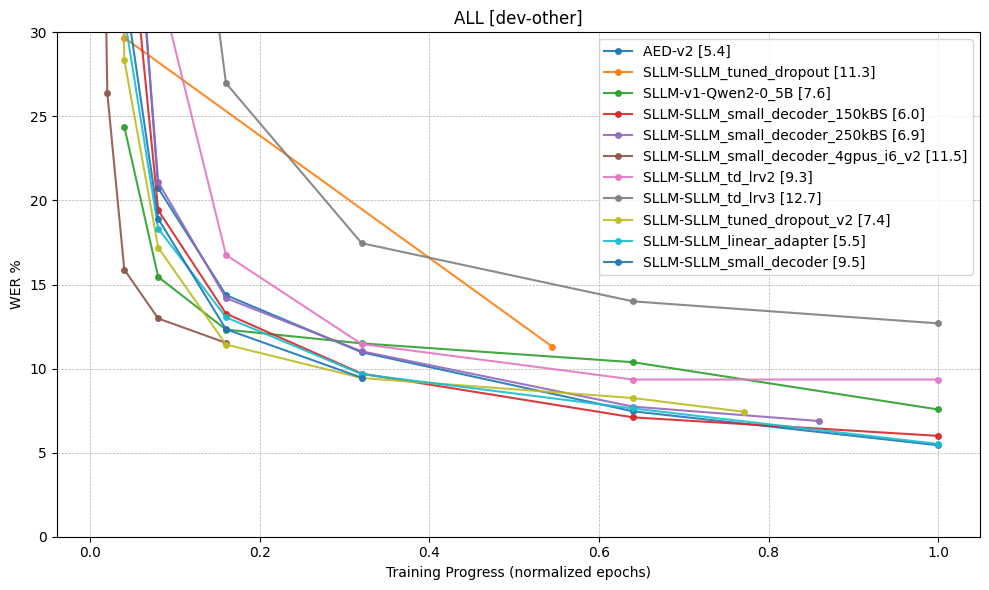

In [68]:
plot_experiments(
    experiments=experiment_results_list,
    title="ALL",
    ylim_max=30,
)

### AED vs SLLM

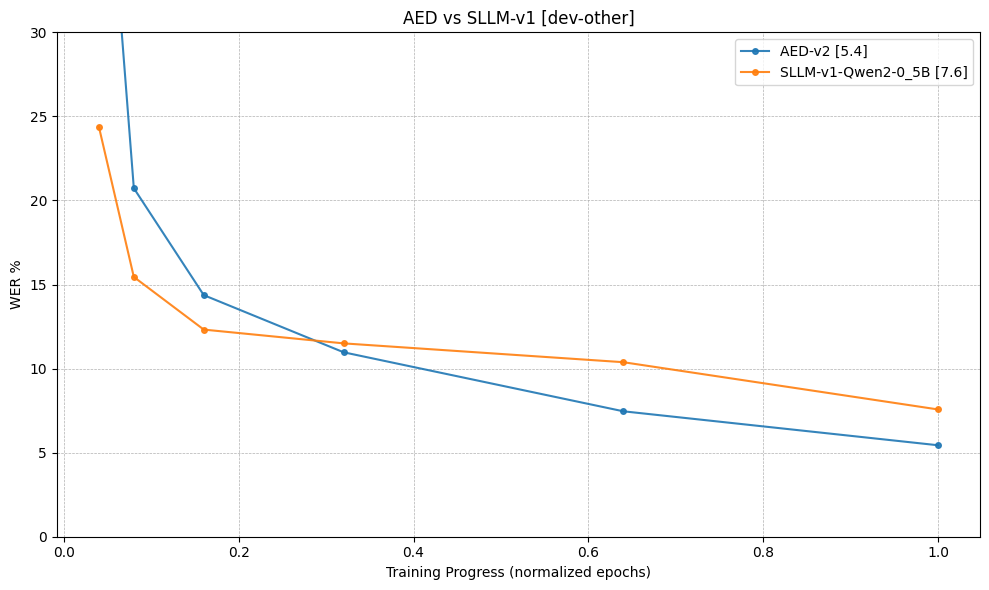

In [75]:
plot_experiments(
    experiments=experiment_results_list,
    include_versions=["v2", "v1-Qwen2-0_5B"],
    title="AED vs SLLM-v1",
)

### Small-decoders

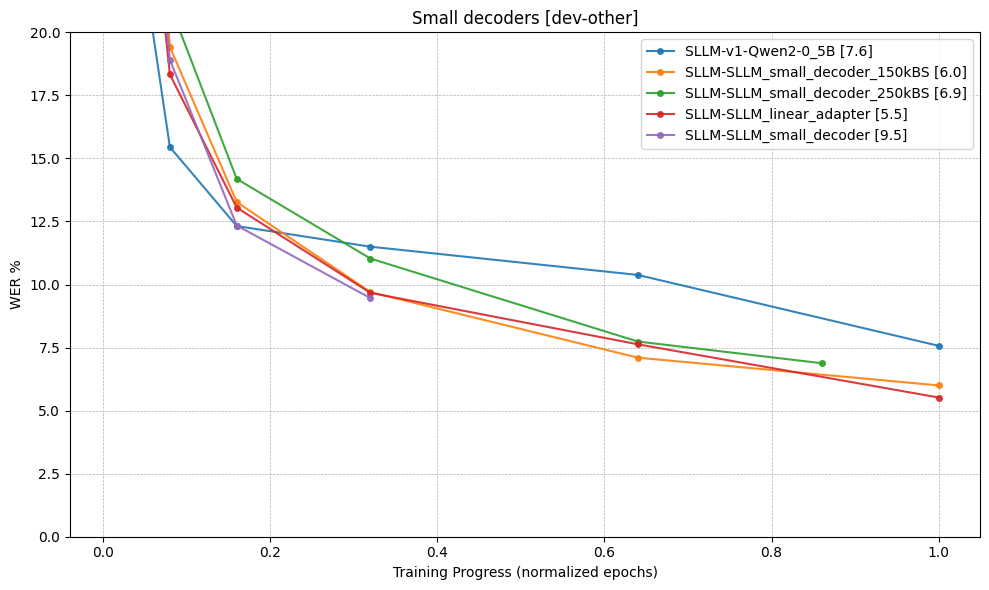

In [81]:
plot_experiments(
    experiments=experiment_results_list,
    include_versions=["v1-Qwen2-0_5B", "SLLM_small_decoder", "SLLM_small_decoder_150kBS", "SLLM_small_decoder_250kBS", "SLLM_linear_adapter"],
    title="Small decoders",
    ylim_max=20,
)

### Base decoders

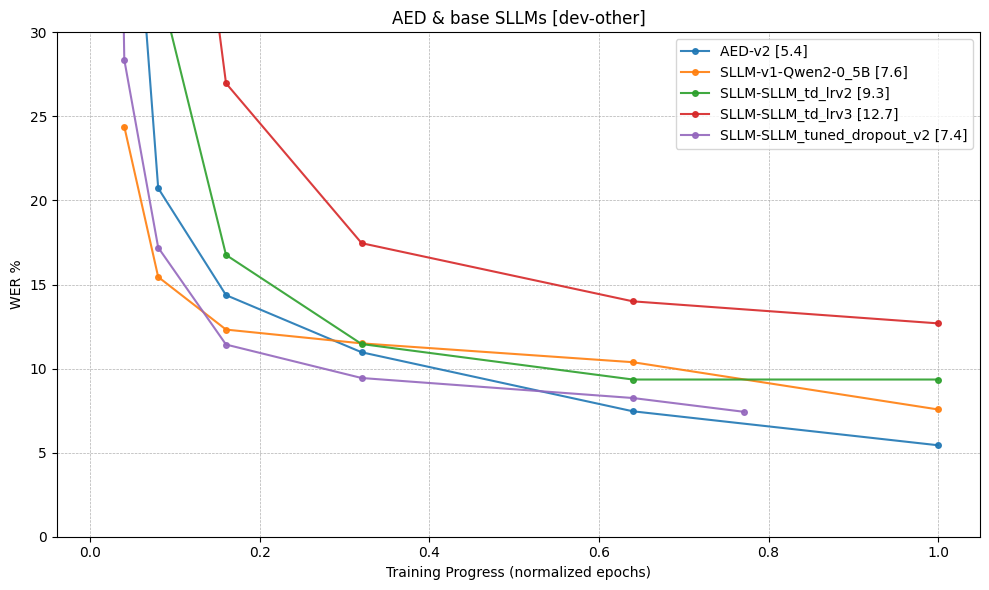

In [77]:
plot_experiments(
    experiments=experiment_results_list,
    include_versions=["v2", "v1-Qwen2-0_5B", "SLLM_tuned_dropout_v2", "SLLM_td_lrv2", "SLLM_td_lrv3"],
    title="AED & base SLLMs",
)

## Best Models [01-01-2025]

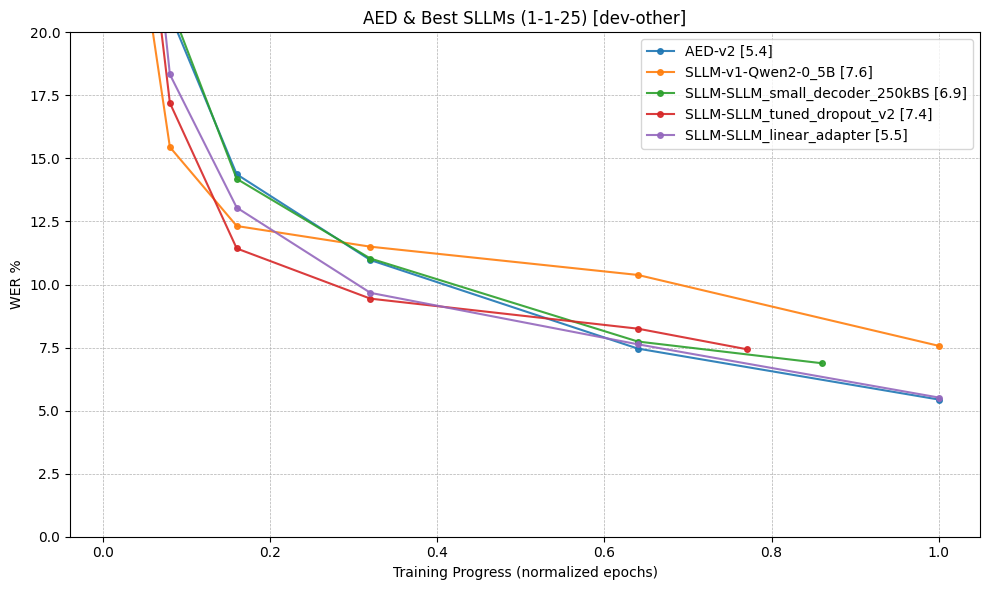

In [82]:
plot_experiments(
    experiments=experiment_results_list,
    include_versions=["v2", "v1-Qwen2-0_5B", "SLLM_tuned_dropout_v2", "SLLM_small_decoder_250kBS", "SLLM_linear_adapter"],
    title="AED & Best SLLMs (1-1-25)",
    ylim_max=20
)